# <i>CatBoost learning to rank on Microsoft dataset</i>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/catboost/tutorials/blob/master/ranking/ranking_tutorial.ipynb)

In [3]:
import matplotlib.pyplot as plt
from catboost import CatBoostRanker, Pool, MetricVisualizer
from copy import deepcopy
import numpy as np
import os
import pandas as pd

### Ranking problem

Let's introduce a notation:
* Let $Q = \{q_1, \dots, q_n\}$ be the set of groups
* $D_q = \{d_{q1}, \dots, d_{qm}\}$ -- set of objects retrieved for a group $q$
* $L_q = \{l_{q1}, \dots, l_{qm}\}$ -- relevance labels for the objects from the set $D_q$

Every object $d_{qi}$ is represented in the vector space of features, describing the associatinos between the group and the object.

So every group is associated with set of objects. For example, group is a query and object is a document if we are ranking documents for a search query.

The goal is to learn the ranking function $f = f(d_{qi})$, such that the ranking of objects $d_{qi}$ for all groups from $Q$ based on their scores $x_{qi} = f(d_{qi})$, is as close as possible to the ideal ranking from the editorial judgements $l_{qi}$.

### Ranking quality metrics:
* __Precision__
    $$ \mbox{P}=\frac{|\{\mbox{relevant docs}\}\cap\{\mbox{retrieved docs}\}|}{|\{\mbox{retrieved docs}\}|} $$
* __Recall__
    $$ \mbox{R}=\frac{|\{\mbox{relevant docs}\}\cap\{\mbox{retrieved docs}\}|}{|\{\mbox{relevant docs}\}|} $$
    
    Notation $@k$ means that metric is calculated on the first $k$ documents from ranking list.

    For example, if 1,2,5,7,9 is the ranks of relevant documents (enumerations starts from number 1) from ten retrivied then $P@5$ will be $\frac{3}{5}$.

* __Mean average precision (MAP)__
    $$\frac{1}{|Q|}\sum_{q \in Q} \frac{1}{|\mbox{relevant docs in } D_q|} \sum_{k} P@k(q) \times rel(q, k) $$
    
    Where $rel(q, k)$ is a relevance label of the document at k-th position in our ranking of $D_q$. This metric calculates average precision for a query weighted with document relevances and then calculate mean between all queries.
    
* __Discounted cumulative gain (DCG)__
    $$\sum_{k=1}^{mq} \frac{2 ^ {l_{qk}}}{\log_2(k+1)}$$
    
    This metric takes into account user behavior: user attention is high on the top and then nonlinear decrease to the end.
    
* __NDCG__ - normalized DCG = DCG $~ / ~$ IDCG, where IDCG is a maximum possible value of DCG with given set of relevance labels.

* __AverageGain__ - represents the average value of the label values for objects with the defined top  label values.

* __[PFound](https://tech.yandex.com/catboost/doc/dg/references/pfound-docpage/#pfound)__
    
More on wiki: https://en.wikipedia.org/wiki/Evaluation_measures_(information_retrieval)

Parameter $@k$ for every metric can be specified through metric parameter "top", for example "NDCG:top=10", would mean NDCG@10.

### Download part of [MSRank](https://www.microsoft.com/en-us/research/project/mslr/) dataset from CatBoost datasets storage

In [4]:
from catboost.datasets import msrank_10k
train_df, test_df = msrank_10k()

X_train = train_df.drop([0, 1], axis=1).values
y_train = train_df[0].values
queries_train = train_df[1].values

X_test = test_df.drop([0, 1], axis=1).values
y_test = test_df[0].values
queries_test = test_df[1].values

# each row in dataset is a query document pair
# 0 column is relevance label
# 1 column is query-id

In [5]:
train_df.head()

,0,1,2,3,4,5,6,7,8,9,...,128,129,130,131,132,133,134,135,136,137
0,2.0,1,3,3,0,0,3,1.0,1.0,0.000000,...,62,11089534,2,116,64034,13,3,0,0,0.0
1,2.0,1,3,0,3,0,3,1.0,0.0,1.000000,...,54,11089534,2,124,64034,1,2,0,0,0.0
2,0.0,1,3,0,2,0,3,1.0,0.0,0.666667,...,45,3,1,124,3344,14,67,0,0,0.0
3,2.0,1,3,0,3,0,3,1.0,0.0,1.000000,...,56,11089534,13,123,63933,1,3,0,0,0.0
4,1.0,1,3,0,3,0,3,1.0,0.0,1.000000,...,64,5,7,256,49697,1,13,0,0,0.0


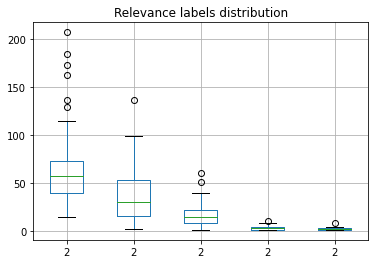

In [25]:
train_df.pivot_table(index=1, columns=0, values=2, aggfunc='count').boxplot()
plt.title('Relevance labels distribution');

### Dataset analysis

__Number of documents__

In [4]:
num_documents = X_train.shape[0]
print(num_documents)

10000


__Number of features__

In [5]:
X_train.shape[1]

136

__Relevance labels statistics__

0 - irrelevant, 1 - highly relevant. Table represents number of documents for each value.

In [8]:
pd.value_counts(y_train)

0.0    5481
1.0    3000
2.0    1326
3.0     142
4.0      51
dtype: int64

For calculation such metrics as NDCG and PFound relevances should be in segment \[0,1\].

In [6]:
max_relevance = np.max(y_train)
y_train /= max_relevance
y_test /= max_relevance

__Number of queries__

In [10]:
num_queries = np.unique(queries_train).shape[0]
num_queries

87

### Creation of CatBoost pools

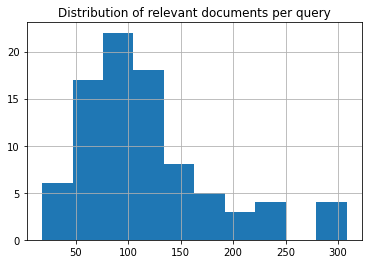

In [18]:
pd.value_counts(queries_train).hist()
plt.title('Distribution of relevant documents per query');

In [7]:
train = Pool(
    data=X_train,
    label=y_train,
    group_id=queries_train,
)

test = Pool(
    data=X_test,
    label=y_test,
    group_id=queries_test
)

### You can also create pools from files

In [49]:
data_dir = './msrank'

if not os.path.exists(data_dir):
    os.makedirs(data_dir)

train_file = os.path.join(data_dir, 'train.csv')
test_file = os.path.join(data_dir, 'test.csv')

train_df.to_csv(train_file, index=False, header=False)
test_df.to_csv(test_file, index=False, header=False)

In [50]:
description_file = os.path.join(data_dir, 'dataset.cd')
with open(description_file, 'w') as f:
    f.write('0\tLabel\n')
    f.write('1\tQueryId\n')

In [51]:
Pool(data=train_file, column_description=description_file, delimiter=',')

### <span style="color:#ce2029">Attention:</span> all objects in dataset must be grouped by group_id

For example, if the dataset consits of five documents 
\[d1, d2, d3, d4, d5\] with corresponding queries \[q1, q2, q2, q1, q2\] then the dataset should be look like:

$$\begin{pmatrix}
    d_1, q_1, f_1\\
    d_4, q_1, f_4\\
    d_2, q_2, f_2\\
    d_3, q_2, f_3\\
    d_5, q_2, f_5\\
\end{pmatrix} \hspace{6px} \texttt{or} \hspace{6px}
\begin{pmatrix}
    d_2, q_2, f_2\\
    d_3, q_2, f_3\\
    d_5, q_2, f_5\\
    d_1, q_1, f_1\\
    d_4, q_1, f_4\\
\end{pmatrix}$$

where $f_i$ is feature vector of i-th document.

### Reducing problem to machine learning task

The first and simplest idea is to try predicting document relevance $l_q$ minimizing RMSE.

$$\frac{1}{N}\sqrt{ \sum_q \sum_{d_{qk}} \left(f(d_{qk}) - l_{qk} \right)^2 }$$

In [8]:
default_parameters = {
    'iterations': 2000,
    'custom_metric': ['NDCG', 'PFound', 'AverageGain:top=10'],
    'verbose': True,
    'metric_period': 100,
    'task_type': 'GPU',
    'devices': '0',
    'random_seed': 0,
}

parameters = {}

In [9]:
def fit_model(loss_function, additional_params=None, train_pool=train, test_pool=test):
    parameters = deepcopy(default_parameters)
    parameters['loss_function'] = loss_function
    parameters['train_dir'] = loss_function
    
    if additional_params is not None:
        parameters.update(additional_params)
        
    model = CatBoostRanker(**parameters)
    model.fit(train_pool, eval_set=test_pool, plot=False)
    
    return model

Lets train the simplest model and also demonstrate precision/recall metrics from introduction.

In [21]:
model = fit_model('RMSE', {'custom_metric': ['PrecisionAt:top=10', 'RecallAt:top=10', 'MAP:top=10']})

/home/sstamenov/miniconda3/envs/kagglehm/lib/python3.8/site-packages/catboost/core.py:6011: RuntimeWarning: Regression loss ('RMSE') ignores an important ranking parameter 'group_id'
  warnings.warn("Regression loss ('{}') ignores an important ranking parameter 'group_id'".format(loss_function), RuntimeWarning)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [27]:
model.get_best_score()

{'learn': {'MAP:top=10': 0.5472907924344704,
  'RecallAt:top=10': 0.9578087940156905,
  'PrecisionAt:top=10': 0.19540229885057472,
  'RMSE': 0.10653904769016405},
 'validation': {'MAP:top=10': 0.1293203613516113,
  'RecallAt:top=10': 0.6395443886921159,
  'PrecisionAt:top=10': 0.0715909090909091,
  'RMSE': 0.18275054601352592}}

In [26]:
pd.DataFrame({
    'name': model.feature_names_,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False).head(15)

,name,importance
133,133,6.334719
107,107,5.941477
10,10,3.127200
7,7,3.001182
127,127,2.838254
54,54,2.819228
13,13,2.789212
129,129,2.756180
14,14,2.431121
132,132,2.168594


### Group weights parameter
Suppose we know that some queries are more important than others for us.<br/>
The word "importance" used here in terms of accuracy or quality of CatBoostRanker prediction for given queries.<br/>
You can pass this additional information for learner using a ``group_weights`` parameter.<br/>
Under the hood, CatBoostRanker uses this weights in loss function simply multiplying it on a group summand.<br/>
So the bigger weight $\rightarrow$ the more attention for query.<br/>
Let's show an example of training procedure with random query weights.

In [45]:
def create_weights(queries):
    query_set = np.unique(queries)
    query_weights = np.random.uniform(size=query_set.shape[0])
    weights = np.zeros(shape=queries.shape)
    
    for i, query_id in enumerate(query_set):
        weights[queries == query_id] = query_weights[i]
    
    return weights
    

train_with_weights = Pool(
    data=X_train,
    label=y_train,
    group_weight=create_weights(queries_train),
    group_id=queries_train
)

test_with_weights = Pool(
    data=X_test,
    label=y_test,
    group_weight=create_weights(queries_test),
    group_id=queries_test
)

model = fit_model(
    'RMSE', 
    additional_params={'train_dir': 'RMSE_weigths'}, 
    train_pool=train_with_weights,
    test_pool=test_with_weights
)

/home/sstamenov/miniconda3/envs/kagglehm/lib/python3.8/site-packages/catboost/core.py:6011: RuntimeWarning: Regression loss ('RMSE') ignores an important ranking parameter 'group_id'
  warnings.warn("Regression loss ('{}') ignores an important ranking parameter 'group_id'".format(loss_function), RuntimeWarning)


Learning rate set to 0.065361
0:	learn: 0.1985682	test: 0.1958774	best: 0.1958774 (0)	total: 21ms	remaining: 42.1s


Metric NDCG:type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric AverageGain:top=10 is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


100:	learn: 0.1754914	test: 0.1812445	best: 0.1812445 (100)	total: 1.23s	remaining: 23.1s
200:	learn: 0.1711317	test: 0.1812379	best: 0.1812379 (200)	total: 2.41s	remaining: 21.6s
300:	learn: 0.1683229	test: 0.1813865	best: 0.1812379 (200)	total: 3.43s	remaining: 19.3s
400:	learn: 0.1658654	test: 0.1815100	best: 0.1812379 (200)	total: 4.44s	remaining: 17.7s
500:	learn: 0.1638719	test: 0.1816599	best: 0.1812379 (200)	total: 5.45s	remaining: 16.3s
600:	learn: 0.1619280	test: 0.1815545	best: 0.1812379 (200)	total: 6.47s	remaining: 15.1s
700:	learn: 0.1605466	test: 0.1815010	best: 0.1812379 (200)	total: 7.48s	remaining: 13.9s
800:	learn: 0.1590907	test: 0.1816039	best: 0.1812379 (200)	total: 8.5s	remaining: 12.7s
900:	learn: 0.1577764	test: 0.1817709	best: 0.1812379 (200)	total: 9.49s	remaining: 11.6s
1000:	learn: 0.1566729	test: 0.1818580	best: 0.1812379 (200)	total: 10.4s	remaining: 10.4s
1100:	learn: 0.1555946	test: 0.1818750	best: 0.1812379 (200)	total: 11.3s	remaining: 9.23s
1200:	lea

In [34]:
model.get_best_score()

{'learn': {'AverageGain:top=10': 0.5064965293560282,
  'RMSE': 0.09525656461436982},
 'validation': {'PFound': 0.6877331164098363,
  'NDCG:type=Base': 0.750261195095063,
  'AverageGain:top=10': 0.2654876431000913,
  'RMSE': 0.18162412032700953}}

### A special case: top-1 prediction

Someday you may face with a problem $-$ you will need to predict the top one most relevant object for a given query.<br/>
For this purpose CatBoostRanker has a mode called __QuerySoftMax__.

Suppose our dataset contain a binary target: 1 $-$ mean best document for a query, 0 $-$ others.<br/>
We will maximize the probability of being the best document for given query.<br/>
MSRANK dataset doesn't contain binary labels, but for example of method __QuerySoftMax__ we convert it to that format,<br/> choosing a best document for every query.

In [35]:
def get_best_documents(labels, queries):
    query_set = np.unique(queries)
    num_queries = query_set.shape[0]
    by_query_arg_max = {query: -1 for query in query_set}
    
    for i, query in enumerate(queries):
        best_idx = by_query_arg_max[query]
        if best_idx == -1 or labels[best_idx] < labels[i]:
            by_query_arg_max[query] = i
    
    binary_best_docs = np.zeros(shape=labels.shape)
    for arg_max in by_query_arg_max.values():
        binary_best_docs[arg_max] = 1.
        
    return binary_best_docs

In [36]:
best_docs_train = get_best_documents(y_train, queries_train)
best_docs_test = get_best_documents(y_test, queries_test)

train_with_weights = Pool(
    data=X_train,
    label=best_docs_train,
    group_id=queries_train,
    group_weight=create_weights(queries_train)
)

test_with_weights = Pool(
    data=X_test,
    label=best_docs_test,
    group_id=queries_test,
    group_weight=create_weights(queries_test)
)

model = fit_model(
    'QuerySoftMax',
    additional_params={'custom_metric': 'AverageGain:top=1'},
    train_pool=train_with_weights,
    test_pool=test_with_weights
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [37]:
model.get_best_score()

{'learn': {'AverageGain:top=1': 0.9993291336878123,
  'QuerySoftMax': 0.042787154203139985},
 'validation': {'AverageGain:top=1': 0.1137165838254637,
  'QuerySoftMax': 4.244513651768611}}

### Reducing ploblem, step 2

Now lets look at example of documents relevance:

$$ 
    \begin{align}
    labels(q_1) &= \begin{bmatrix}
           4 \\
           3 \\
           3 \\
           1
         \end{bmatrix},
    labels(q_2) &= \begin{bmatrix}
           2 \\
           1 \\
           1 \\
           0
         \end{bmatrix}
   \end{align}
$$

This means that with RMSE loss function we pay more attention to q1 than q2. 

To avoid this problem we introduce into RMSE a coefficient $c_q$ which depends only on query (and if fact equals to the mean of the difference between prediction and label).

$$\frac{1}{N}\sqrt{ \sum_q \sum_{d_{qk}} \left(f(d_{qk}) - l_{qk} - \color{red}{c_{q}} \right)^2 }$$

In [38]:
model = fit_model('QueryRMSE')

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [39]:
model.get_best_score()

{'learn': {'AverageGain:top=10': 0.47528735632183894,
  'QueryRMSE': 0.12417683344349269},
 'validation': {'PFound': 0.7055757583875754,
  'NDCG:type=Base': 0.7555343291436938,
  'AverageGain:top=10': 0.2636363636363637,
  'QueryRMSE': 0.17507349419509302}}

### Reducing problem, step 3

Since the goal of ranking is to predict a list of documents (which can be generated from given document relevances) RMSE loss function doesn't take into account relations between documents: the first is better than second, second is better than third and fifth etc.

We can easily bring this information into the loss function, reducing problem not to regression but classification for two documents $(d_i, d_j)$ -- does $i$th better than $j$th or not.

So we minimize the negative loglikelihood:

$$ - \sum_{i,j \in Pairs} \log \left( \frac{1}{1 + \exp{-(f(d_i) - f(d_j))}} \right) $$

Methods based on pair comparisons called __pairwise__ in CatBoostRanker this objective called __PairLogit__.

There's no need to change the dataset CatBoost generate the pairs for us. The number of generating pairs managed via parameter max_size.

In [46]:
model = fit_model('PairLogit')

Metric NDCG:type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric AverageGain:top=10 is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.6897058	test: 0.6907011	best: 0.6907011 (0)	total: 51.1ms	remaining: 1m 42s
100:	learn: 0.5911733	test: 0.6420131	best: 0.6420131 (100)	total: 2.77s	remaining: 52s
200:	learn: 0.5649748	test: 0.6383494	best: 0.6383494 (200)	total: 5.53s	remaining: 49.5s
300:	learn: 0.5466273	test: 0.6376793	best: 0.6376793 (300)	total: 8.33s	remaining: 47s
400:	learn: 0.5288810	test: 0.6386064	best: 0.6376793 (300)	total: 11.2s	remaining: 44.5s
500:	learn: 0.5144261	test: 0.6391934	best: 0.6376793 (300)	total: 14s	remaining: 41.8s
600:	learn: 0.4995952	test: 0.6396274	best: 0.6376793 (300)	total: 16.8s	remaining: 39.2s
700:	learn: 0.4867026	test: 0.6410659	best: 0.6376793 (300)	total: 19.7s	remaining: 36.4s
800:	learn: 0.4769803	test: 0.6410113	best: 0.6376793 (300)	total: 22.5s	remaining: 33.7s
900:	learn: 0.4691782	test: 0.6426873	best: 0.6376793 (300)	total: 25.3s	remaining: 30.9s
1000:	learn: 0.4620465	test: 0.6451779	best: 0.6376793 (300)	total: 28.1s	remaining: 28.1s
1100:	learn: 0.45

Also we can to specify the pairs directly. There are two ways to do that:

1. Two-dimensional matrix with shape=(num_pairs, 2) $\rightarrow$ (winner_id, loser_id): list, numpy.array, pandas.DataFrame.
2. Path two the input file that contains pair descriptions:
    * Row format: $\texttt{[winner index, loser index, pair weight]}$

In [47]:
model.get_best_score()

{'learn': {'AverageGain:top=10': 0.3919540229885057,
  'PairLogit': 0.4168368807478197},
 'validation': {'PFound': 0.6942302783326958,
  'NDCG:type=Base': 0.7437263506825026,
  'AverageGain:top=10': 0.25965909090909095,
  'PairLogit': 0.6376792693372165}}

In [52]:
def read_groups(file_name):
    groups = {}
    group_ids = []

    with open(file_name) as f:
        for doc_id, line in enumerate(f):
            line = line.split(',')[:2]
            
            label, query_id = float(line[0]), int(line[1])
            if query_id not in groups:
                groups[query_id] = []
            groups[query_id].append((doc_id, label))

            group_ids.append(query_id)

    return groups, group_ids
            
train_groups, train_group_ids = read_groups(train_file)
assert num_queries == len(train_groups)

In [53]:
pairs = []

for group in train_groups.values():
    for i in range(len(group)):
        for j in range(i, len(group)):
            if i == j:
                continue
            doc_i, relevance_i = group[i]
            doc_j, relevance_j = group[j]
            if relevance_i < relevance_j:
                pairs.append((doc_j, doc_i))
            else:
                pairs.append((doc_i, doc_j))
                
pairs_file = os.path.join(data_dir, 'pairs.csv')

with open(pairs_file, 'w') as f:
    for pair in pairs:
        f.write(str(pair[0]) + '\t' + str(pair[1]) + '\t1\n')

In [54]:
pool1 = Pool(data=X_train, label=y_train, group_id=train_group_ids, pairs=pairs)
pool2 = Pool(data=train_file, column_description=description_file, pairs=pairs_file, delimiter=',')

### Reducing problem, step 3.1

Thus we know that $f(d_{qk})$ is a ensemble of trees, we can accurately solve the minimization task from step 3.

This method called __PairLogitPairwise__.

In [55]:
model = fit_model('PairLogitPairwise')

Metric NDCG:type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric AverageGain:top=10 is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.6893803	test: 0.6907359	best: 0.6907359 (0)	total: 40.7ms	remaining: 1m 21s
100:	learn: 0.5639202	test: 0.6366385	best: 0.6366385 (100)	total: 1.94s	remaining: 36.4s
200:	learn: 0.5189296	test: 0.6318639	best: 0.6318639 (200)	total: 3.73s	remaining: 33.4s
300:	learn: 0.4816323	test: 0.6308098	best: 0.6308098 (300)	total: 5.53s	remaining: 31.2s
400:	learn: 0.4509807	test: 0.6304736	best: 0.6304736 (400)	total: 7.33s	remaining: 29.2s
500:	learn: 0.4230745	test: 0.6315715	best: 0.6304736 (400)	total: 9.14s	remaining: 27.3s
600:	learn: 0.3992476	test: 0.6330836	best: 0.6304736 (400)	total: 10.9s	remaining: 25.5s
700:	learn: 0.3775283	test: 0.6354034	best: 0.6304736 (400)	total: 12.7s	remaining: 23.6s
800:	learn: 0.3582875	test: 0.6371145	best: 0.6304736 (400)	total: 14.5s	remaining: 21.8s
900:	learn: 0.3399309	test: 0.6390522	best: 0.6304736 (400)	total: 16.4s	remaining: 19.9s
1000:	learn: 0.3227226	test: 0.6413806	best: 0.6304736 (400)	total: 18.2s	remaining: 18.1s
1100:	learn

In [56]:
model.get_best_score()

{'learn': {'AverageGain:top=10': 0.4589080459770114,
  'PairLogit': 0.20917523288347004},
 'validation': {'PFound': 0.6969708692991746,
  'NDCG:type=Base': 0.7485915858518861,
  'AverageGain:top=10': 0.2599431818181817,
  'PairLogit': 0.6304735760224252}}

### Reducing problem, step 4

Previous loss function directly minimize the number of pairs $(d_i, d_j)$ where $l_i > l_j$ but $f(d_i) < f(d_j)$, simply said the number of incorrectly placed documents.

Since the user attention is high on the first documents and low on last the incorrect switch of the first two documents and last two has different cost.

In steps 3 and 3.1 user can set the weight for pair.

Method __YetiRank__ take this effect into account and generates weights for pairs according to their positions ([paper](https://cache-mskstoredata08.cdn.yandex.net/download.yandex.ru/company/to_rank_challenge_with_yetirank.pdf)).

$$ - \sum_{i,j \in Pairs} \color{red}{w_{ij}} \log \left( \frac{1}{1 + \exp{-(f(d_i) - f(d_j))}} \right) $$

In [57]:
model = fit_model('YetiRank')

Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric NDCG:type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric AverageGain:top=10 is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.4794952	best: 0.4794952 (0)	total: 22.1ms	remaining: 44.2s
100:	test: 0.6754177	best: 0.6754177 (100)	total: 1.38s	remaining: 26s
200:	test: 0.6888809	best: 0.6888809 (200)	total: 2.69s	remaining: 24.1s
300:	test: 0.6999734	best: 0.6999734 (300)	total: 3.99s	remaining: 22.5s
400:	test: 0.7040829	best: 0.7040829 (400)	total: 5.3s	remaining: 21.1s
500:	test: 0.7025046	best: 0.7040829 (400)	total: 6.61s	remaining: 19.8s
600:	test: 0.7020804	best: 0.7040829 (400)	total: 7.92s	remaining: 18.4s
700:	test: 0.7040818	best: 0.7040829 (400)	total: 9.22s	remaining: 17.1s
800:	test: 0.7010248	best: 0.7040829 (400)	total: 10.5s	remaining: 15.8s
900:	test: 0.6962643	best: 0.7040829 (400)	total: 11.9s	remaining: 14.5s
1000:	test: 0.6982147	best: 0.7040829 (400)	total: 13.2s	remaining: 13.1s
1100:	test: 0.7008561	best: 0.7040829 (400)	total: 14.5s	remaining: 11.8s
1200:	test: 0.7022368	best: 0.7040829 (400)	total: 15.8s	remaining: 10.5s
1300:	test: 0.7018676	best: 0.7040829 (400)	total: 17.

In [58]:
model.get_best_score()

{'learn': {'AverageGain:top=10': 0.37499999999999983},
 'validation': {'NDCG:type=Base': 0.7488483022049874,
  'PFound': 0.7047155572928794,
  'AverageGain:top=10': 0.2650568181818182}}

### Step 4.1

As in step 3.1 __YetiRankPairwise__ is slower than __YetiRank__, but gives more accurate results.

In [10]:
model = fit_model('YetiRankPairwise')

Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric NDCG:type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric AverageGain:top=10 is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.5275414	best: 0.5275414 (0)	total: 24.3ms	remaining: 48.6s
100:	test: 0.6815594	best: 0.6815594 (100)	total: 1.54s	remaining: 29.1s
200:	test: 0.6909609	best: 0.6909609 (200)	total: 3.01s	remaining: 26.9s
300:	test: 0.6908462	best: 0.6909609 (200)	total: 4.48s	remaining: 25.3s
400:	test: 0.6927097	best: 0.6927097 (400)	total: 5.94s	remaining: 23.7s
500:	test: 0.6943018	best: 0.6943018 (500)	total: 7.4s	remaining: 22.1s
600:	test: 0.6940887	best: 0.6943018 (500)	total: 8.85s	remaining: 20.6s
700:	test: 0.6951791	best: 0.6951791 (700)	total: 10.3s	remaining: 19.1s
800:	test: 0.6980429	best: 0.6980429 (800)	total: 11.7s	remaining: 17.6s
900:	test: 0.6978350	best: 0.6980429 (800)	total: 13.2s	remaining: 16.1s
1000:	test: 0.6957414	best: 0.6980429 (800)	total: 14.6s	remaining: 14.6s
1100:	test: 0.6955567	best: 0.6980429 (800)	total: 16.1s	remaining: 13.1s
1200:	test: 0.6950036	best: 0.6980429 (800)	total: 17.6s	remaining: 11.7s
1300:	test: 0.6951498	best: 0.6980429 (800)	total: 1

In [11]:
model.get_best_score()

{'learn': {'AverageGain:top=10': 0.40890804597701147},
 'validation': {'NDCG:type=Base': 0.7524265747946437,
  'PFound': 0.7018180650026347,
  'AverageGain:top=10': 0.2667613636363638}}

In [60]:
widget = MetricVisualizer(['RMSE', 'QueryRMSE', 'PairLogit', 'PairLogitPairwise', 'YetiRank', 'YetiRankPairwise'])
widget.start()

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

### Simple classification

Very fast $\rightarrow$ very slow; Simple method $\rightarrow$ complex method; Low quality $\rightarrow$ high quality.

1. RMSE
2. QueryRMSE
3. PairLogit
4. PairLogitPairwise
5. YetiRank
6. YetiRankPairwise

Besides our classification, the quality of the concrete method may depend on your dataset.

Look on NDCG metric of method YetiRank $-$ it's underfitted.

In [62]:
model = fit_model('YetiRank', {'train_dir': 'YetiRank-lr-0.3', 'learning_rate': 0.3})

Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric NDCG:type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric AverageGain:top=10 is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.4794952	best: 0.4794952 (0)	total: 19.9ms	remaining: 39.8s
100:	test: 0.7114558	best: 0.7114558 (100)	total: 1.37s	remaining: 25.8s
200:	test: 0.7123913	best: 0.7123913 (200)	total: 2.67s	remaining: 23.9s
300:	test: 0.7137171	best: 0.7137171 (300)	total: 3.96s	remaining: 22.4s
400:	test: 0.7078599	best: 0.7137171 (300)	total: 5.26s	remaining: 21s
500:	test: 0.7023283	best: 0.7137171 (300)	total: 6.54s	remaining: 19.6s
600:	test: 0.7011803	best: 0.7137171 (300)	total: 7.83s	remaining: 18.2s
700:	test: 0.6927510	best: 0.7137171 (300)	total: 9.12s	remaining: 16.9s
800:	test: 0.6928724	best: 0.7137171 (300)	total: 10.4s	remaining: 15.6s
900:	test: 0.6963260	best: 0.7137171 (300)	total: 11.7s	remaining: 14.3s
1000:	test: 0.6990880	best: 0.7137171 (300)	total: 13s	remaining: 13s
1100:	test: 0.6972629	best: 0.7137171 (300)	total: 14.3s	remaining: 11.7s
1200:	test: 0.6973643	best: 0.7137171 (300)	total: 15.6s	remaining: 10.4s
1300:	test: 0.7008261	best: 0.7137171 (300)	total: 16.8s	

In [12]:
predictions = model.predict(test)

In [17]:
from catboost.utils import eval_metric

eval_metric(y_test, predictions, 'MAP:top=12', group_id=queries_test)

[0.13768747745310245]

In [78]:
pd.DataFrame({
    'label': y_test,
    'prediction': predictions
}, index=queries_test).loc[28].sort_values(by='prediction', ascending=False)

,label,prediction
28,0.75,0.171162
28,0.25,0.105966
28,0.25,0.007418
28,0.75,-0.087417
28,0.00,-0.317539
...,...,...
28,0.00,-2.058155
28,0.00,-2.206252
28,0.00,-2.475829
28,0.00,-2.480184


In [75]:
set(queries_test)

{13,
 28,
 43,
 58,
 73,
 88,
 103,
 118,
 133,
 148,
 163,
 178,
 193,
 208,
 223,
 238,
 253,
 268,
 283,
 298,
 313,
 328,
 343,
 358,
 373,
 388,
 403,
 418,
 433,
 448,
 463,
 478,
 493,
 508,
 523,
 538,
 553,
 568,
 583,
 598,
 613,
 628,
 643,
 658,
 673,
 688,
 703,
 718,
 733,
 748,
 763,
 778,
 793,
 808,
 823,
 838,
 853,
 868,
 883,
 898,
 913,
 928,
 943,
 958,
 973,
 988,
 1003,
 1018,
 1033,
 1048,
 1063,
 1078,
 1093,
 1108,
 1123,
 1138,
 1153,
 1168,
 1183,
 1198,
 1213,
 1228,
 1243,
 1258,
 1273,
 1288,
 1303,
 1318}

In [ ]:
widget = MetricVisualizer(['YetiRank', 'YetiRank-lr-0.3'])
widget.start()

### Additional parameters

__Metric period__

Period in iterations of calculation metrics. This parameter can speed up training process.

In [ ]:
fit_model('YetiRank', {'metric_period': 50})

__Task type__

You can significantly speed up training procedure switching to gpu.

In [ ]:
fit_model('YetiRank', {'task_type': 'GPU'})